# Part 2: Find Evidence of Distribution Shift

Covariate Shift: 
* Example Question "ST253Q01JA" -- "How many [digital devices] with screens are there in your [home]?" histogram between Australia, Belgium, United States vs. Jordan, Philippines
* BTW, thats the most important feature picked up by this version of the Linear Regression

Label Shift:
* PV1_Math histogram differs between Australia, Belgium, United States vs. Jordan, Philippines

Probably some funky distribution shift going on when training on Australia/United States and testing on Belgium

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

import ml_insights as mli

In [2]:
def plot_confusion_regression(y_test, y_pred, quartiles=4):
    true_binned = pd.qcut(y_test, q=quartiles, precision=0)
    print("Y Test Binned Value Counts")
    display(true_binned.value_counts())

    pred_binned = pd.cut(y_pred, bins=true_binned.value_counts().index.to_list())
    print("Y Pred Binned Value Counts")
    display(pred_binned.value_counts())

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(true_binned.astype(str), pred_binned.astype(str), labels=[str(x) for x in true_binned.value_counts().index.to_list()])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(x) for x in true_binned.value_counts().index.to_list()])
    disp.plot()

In [3]:
ALPHA = 0.5
coefs_LASSO = pd.read_csv(f'LASSO_coef_alpha_{ALPHA}_NO_PV.csv', header=0, index_col=0)
coefs_LASSO

,Coefficients importance
CNTRYID,1.570051
CNTSCHID,0.000000
CNTSTUID,0.000000
OECD,-3.191918
ADMINMODE,-1.236478
...,...
CREATACT,0.000000
CREATOPN,-1.335293
CREATOR,-0.000000
UNIT,-0.000000


In [4]:
X = pd.read_csv('cleaned_data/X_train.csv', header=0, index_col=0)
y = pd.read_csv('cleaned_data/y_train.csv', header=None, index_col=None).values.ravel()

X = X.set_index(["CNTSTUID"])
X = X.filter(items=coefs_LASSO[coefs_LASSO["Coefficients importance"] != 0].index)
X = X.drop(columns=X.filter(regex="PV.*").columns)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Test Features: {}".format(X_test.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Test Target: {}".format(y_test.shape))

Shape of Train Features: (200554, 384)
Shape of Test Features: (133704, 384)
Shape of Train Target: (200554,)
Shape of Test Target: (133704,)


Text(0.5, 1.0, 'Philippines (red), Jordan (orange)')

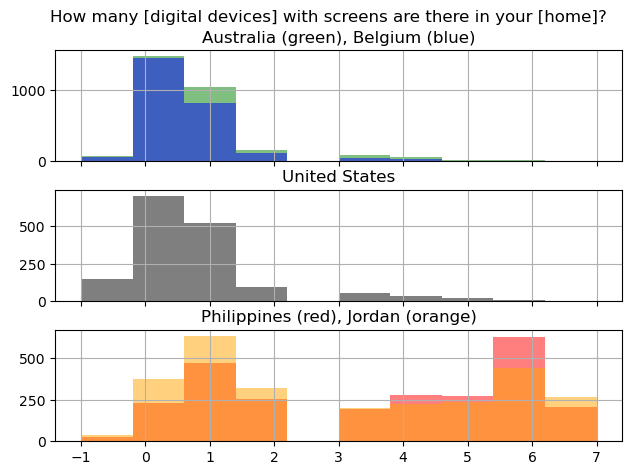

In [6]:
fig, ax = plt.subplots(3, sharex=True)
question = "ST253Q01JA"
fig.suptitle("How many [digital devices] with screens are there in your [home]?")
fig.tight_layout()

X_train[X_train["CNTRYID"] == 5][question].hist(alpha=0.5, color="green", ax=ax[0])
X_train[X_train["CNTRYID"] == 2][question].hist(alpha=0.5, color="blue", ax=ax[0])
ax[0].set_title('Australia (green), Belgium (blue)')
X_train[X_train["CNTRYID"] == 76][question].hist(alpha=0.5, color="black", ax=ax[1])
ax[1].set_title('United States')
X_train[X_train["CNTRYID"] == 57][question].hist(alpha=0.5, color="red", ax=ax[2])
X_train[X_train["CNTRYID"] == 36][question].hist(alpha=0.5, color="orange", ax=ax[2])
ax[2].set_title('Philippines (red), Jordan (orange)')

Text(0.5, 1.0, 'Philippines (red), Jordan (orange)')

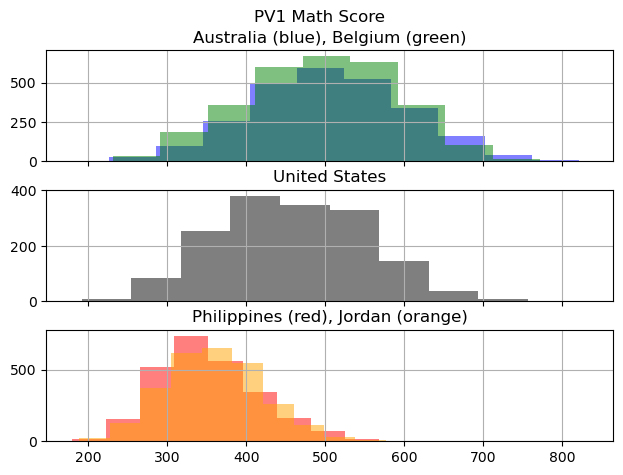

In [7]:
fig, ax = plt.subplots(3, sharex=True)
question = "y_train"
fig.suptitle("PV1 Math Score")
fig.tight_layout()

df = pd.DataFrame({
    "y_train": y_train,
    "CNTSTUID": X_train.index
}).set_index("CNTSTUID")

df = df.merge(X_train, left_index=True, right_index=True)

df[df["CNTRYID"] == 2][question].hist(alpha=0.5, color="blue", ax=ax[0]) 
df[df["CNTRYID"] == 5][question].hist(alpha=0.5, color="green", ax=ax[0])
ax[0].set_title('Australia (blue), Belgium (green)')
df[df["CNTRYID"] == 76][question].hist(alpha=0.5, color="black", ax=ax[1])
ax[1].set_title('United States')
df[df["CNTRYID"] == 57][question].hist(alpha=0.5, color="red", ax=ax[2])
df[df["CNTRYID"] == 36][question].hist(alpha=0.5, color="orange", ax=ax[2])
ax[2].set_title('Philippines (red), Jordan (orange)')

## Train a Linear Model on Australia, United States, then ALSO test on Belgium, Jordan, Philippines

In [8]:
df = pd.DataFrame({
    "y_train": y_train,
    "CNTSTUID": X_train.index
}).set_index("CNTSTUID")
df = df.merge(X_train, left_index=True, right_index=True)

# drop columns that are null across all instances of given country
df_drop = (df[df["CNTRYID"].isin([2, 5, 76, 36, 57])].set_index("CNTRYID", append=True).notna().reset_index(level=1).groupby("CNTRYID").sum() == 0).sum(axis=0) > 0
df_drop = df_drop[df_drop]
df = df.drop(columns=df_drop.index)

X_train_aus_us = df[df["CNTRYID"].isin([2, 76])].drop(columns=["y_train"])
y_train_aus_us = df[df["CNTRYID"].isin([2, 76])]["y_train"]

test_sets_X = {}
test_sets_y = {}
plot_colors = {
    "Australia": "bo",
    "United States": "ko",
    "Belgium": "go",
    "Philippines": "ro",
    "Jordan": "mo"
}

d = {
    "Australia": 2,
    "United States": 76,
    "Belgium": 5,
    "Philippines": 57,
    "Jordan": 36
}
for country, cid in d.items():
    test_sets_X[country] = df[df["CNTRYID"]== cid].drop(columns=["y_train"])
    test_sets_y[country] = df[df["CNTRYID"]== cid]["y_train"]

Linear Regression Model
Australia 	Test MSE: 2975.810162400636
Australia 	Test MAE: 42.95719320536371


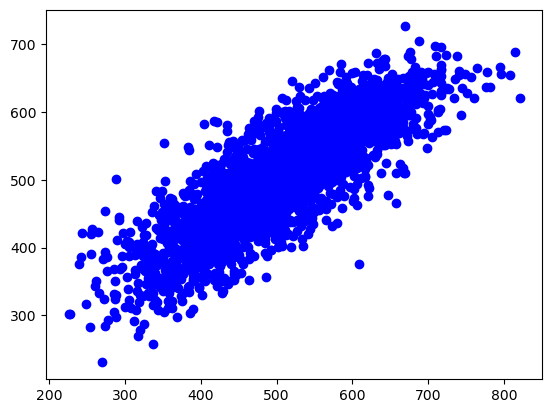

United States 	Test MSE: 3024.48428967023
United States 	Test MAE: 43.658192703093995


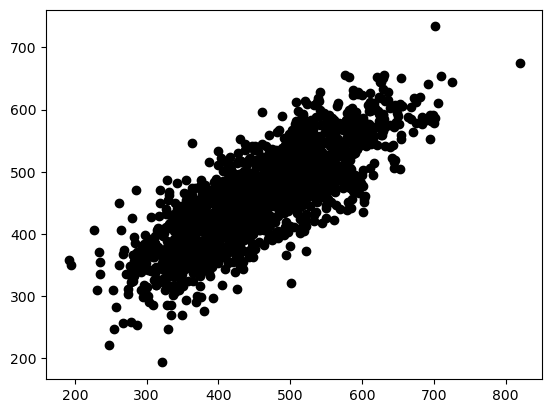

Belgium 	Test MSE: 1.6893580783133315e+28
Belgium 	Test MAE: 111515469465721.42


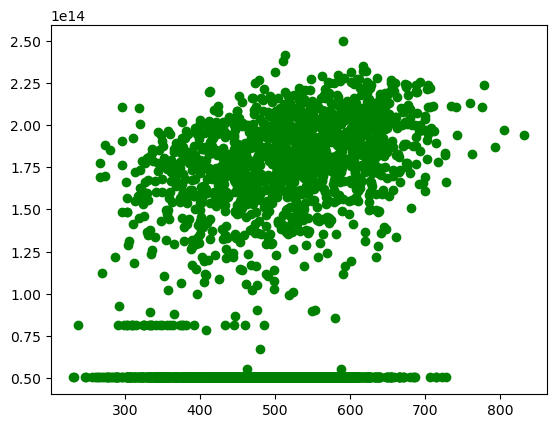

Philippines 	Test MSE: 2.7281421784127697e+28
Philippines 	Test MAE: 165170886611798.8


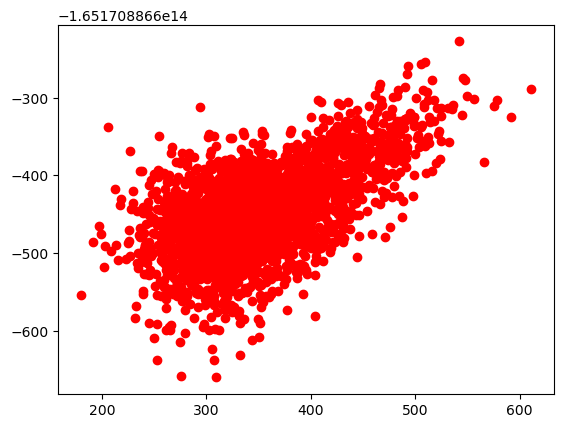

Jordan 	Test MSE: 1.6612880842577485e+27
Jordan 	Test MAE: 40758901902010.91


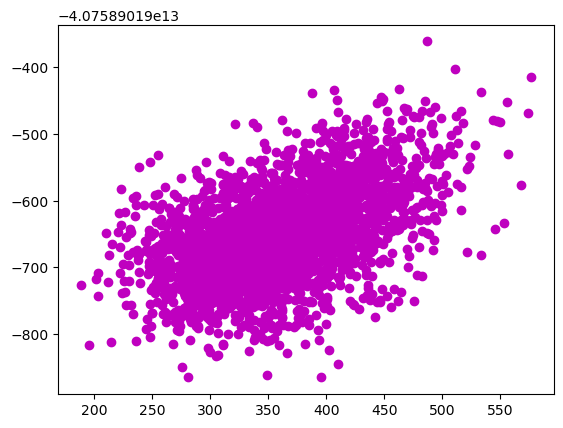

In [9]:
pipe_lr_sel = Pipeline([
        ('imputer', SimpleImputer(add_indicator=True)), 
        ('scaler', StandardScaler()), 
        ('lr', LinearRegression())
    ])

print("Linear Regression Model")
pipe_lr_sel.fit(X_train_aus_us, y_train_aus_us)

# Calculate MSE and MAE
for country, df_X in test_sets_X.items():
    y_val = test_sets_y[country]
    
    y_pred_lr = pipe_lr_sel.predict(df_X)
    mse = mean_squared_error(y_val, y_pred_lr)
    mae = mean_absolute_error(y_val, y_pred_lr)

    # Report results
    print(f"{country} \tTest MSE: {mse}")
    print(f"{country} \tTest MAE: {mae}")

    plt.plot(y_val, y_pred_lr, plot_colors[country])
    plt.show()

## Detect Instance of Distribution Shift

In [10]:
df = pd.DataFrame({
    "y_train": y_train,
    "CNTSTUID": X_train.index
}).set_index("CNTSTUID")

df = df.merge(X_train, left_index=True, right_index=True).sort_values("y_train")

# only look at columns with no nans
df = df.filter(items=df.isna().sum()[df.isna().sum() == 0].index)
display(df)

# Identify countries with high counts (+US, which has 12th LOWEST count) + span across low-high means
# 57: Philippines, # students=1710, mean=353.387445
# 36: Jordan, # students=1792, mean=358.799411
# 76: United States, # students=1051, mean=465.318919
# 5: Belgium, # students=1896, mean=498.645336
# 2: Australia, # students=1698, mean=498.722721
display(df.groupby("CNTRYID")[["y_train"]].agg(["count", "mean", "min", "max"]).sort_values([("y_train", "count")], ascending=False).head(20).sort_values([("y_train", "mean")]))

# filter down to selected countries
df = df[df["CNTRYID"].isin([57, 36, 76, 5, 2])].groupby("CNTRYID").mean().reset_index()
df["label"] = df["CNTRYID"].astype(str).map({"57": "low", "36": "low", "76": "US", "5": "high", "2": "high"})

,y_train,CNTRYID,OECD,ADMINMODE,Option_CT,Option_FL,Option_ICTQ,Option_PQ,ST001D01T,ST004D01T,...,REPEAT,MISSSC,SKIPPING,TARDYSD,WORKPAY,EXPECEDU,MATHMOT,DURECEC,HISCED,FCFMLRTY
CNTSTUID,,,,,,,,,,,,,,,,,,,,,
32004777.0,57.755,26,1,1,1,1,1,1,0,1,...,1,0,0,0,10,-1,-1,-1,-1,-1
11602073.0,87.938,9,1,1,1,1,1,1,1,0,...,0,0,-1,2,-1,4,-1,-1,9,-1
11602835.0,97.962,9,1,1,1,1,1,1,1,1,...,0,0,0,1,7,6,-1,-1,9,-1
801672.0,99.708,0,1,0,0,1,0,1,3,0,...,0,0,0,-1,-1,6,-1,7,0,-1
11602459.0,104.127,9,1,1,1,1,1,1,3,0,...,0,0,0,0,4,5,-1,8,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44601476.0,858.239,42,1,0,0,1,0,0,3,0,...,1,1,1,1,10,7,1,5,2,-1
34405418.0,861.299,27,1,0,0,1,0,0,3,0,...,1,1,1,1,10,4,1,5,7,-1
41006855.0,866.688,38,0,0,0,1,0,0,3,0,...,1,1,1,1,10,7,1,6,7,-1


y_train                              
          count        mean      min      max
CNTRYID                                      
57         2568  351.491662  179.564  611.150
36         2743  359.309422  188.458  576.652
53         2584  362.241739  170.510  599.730
78         2571  366.818441  144.975  620.053
30         4616  381.643945  188.004  657.591
1          4079  389.927900  178.188  686.130
13         2630  393.922042  162.193  707.297
4          2775  399.283915  176.386  725.040
60         2696  408.814519  155.540  727.126
71         2887  417.457660  194.186  790.713
74         8048  434.335356  118.617  823.301
37         6734  449.112094  180.819  735.714
72         2531  453.283667  180.311  769.619
21         3558  474.248351  180.845  764.265
33         3607  478.341494  189.561  767.844
68        10582  480.340511  214.476  772.602
75         4448  482.421122  159.643  850.358
10         7615  484.898777  129.010  828.948
5          2961  496.105547  231.225  832.362
2          2548  504.013149  225.684  820.948

In [11]:
df_ = pd.DataFrame({
    "lowestHigh": df.groupby("label").min().loc["high"],
    "highestLow": df.groupby("label").max().loc["low"],
    "US": df.groupby("label").mean().loc["US"],
})

col_filt = df_[((df_["lowestHigh"] > df_["US"]) & (df_["US"] > df_["highestLow"]) | (df_["lowestHigh"] < df_["US"]) & (df_["US"] < df_["highestLow"]))].index.to_list()
col_filt

['y_train',
 'ST250Q01JA',
 'ST250Q02JA',
 'ST250Q03JA',
 'ST251Q06JA',
 'ST253Q01JA',
 'ST254Q02JA',
 'ST254Q03JA',
 'ST254Q04JA',
 'ST254Q05JA',
 'ST254Q06JA',
 'ST255Q01JA',
 'ST256Q01JA',
 'ST256Q06JA',
 'ST256Q07JA',
 'ST006Q01JA',
 'ST006Q03JA',
 'ST006Q05JA',
 'ST008Q01JA',
 'ST008Q05JA',
 'ST258Q01JA',
 'ST022Q01TA',
 'ST126Q01TA',
 'ST260Q03JA',
 'ST261Q01JA',
 'ST261Q08JA',
 'ST261Q11JA',
 'ST062Q02TA',
 'ST034Q02TA',
 'ST038Q08NA',
 'ST265Q03JA',
 'ST266Q01JA',
 'ST294Q02JA',
 'ST294Q04JA',
 'ST295Q01JA',
 'ST295Q04JA',
 'ST263Q04JA',
 'ST296Q02JA',
 'ST270Q01JA',
 'ST283Q01JA',
 'ST283Q07JA',
 'ST283Q09JA',
 'ST275Q05WA',
 'ST275Q07WA',
 'ST275Q09WA',
 'ST276Q05JA',
 'ST276Q09JA',
 'ST268Q01JA',
 'ST268Q02JA',
 'ST268Q03JA',
 'ST268Q05JA',
 'ST290Q01WA',
 'ST290Q02WA',
 'ST290Q03WA',
 'ST290Q05WA',
 'ST290Q07WA',
 'ST290Q08WA',
 'ST291Q01JA',
 'ST291Q09JA',
 'ST289Q02JA',
 'ST289Q04JA',
 'ST289Q06JA',
 'ST289Q10WA',
 'ST289Q14JA',
 'ST293Q06JA',
 'ST293Q07JA',
 'ST297Q01JA'

## Train Model to Get Coefficients

In [12]:
X_train_all = X_train.filter(items=col_filt)
X_test_all = X_test.filter(items=col_filt)

Linear Regression Model
coefficient of determination of the prediction: 0.5113993354195414
Test MSE: 5077.5743596487255
Test MAE: 56.42924861489366
Y Test Binned Value Counts


(88.0, 317.0]     13371
(317.0, 353.0]    13370
(353.0, 381.0]    13370
(381.0, 408.0]    13371
(408.0, 436.0]    13371
(436.0, 465.0]    13369
(465.0, 497.0]    13371
(497.0, 533.0]    13370
(533.0, 583.0]    13370
(583.0, 868.0]    13371
Name: count, dtype: int64

Y Pred Binned Value Counts


(88.0, 317.0]      5564
(317.0, 353.0]     9068
(353.0, 381.0]    11635
(381.0, 408.0]    17376
(408.0, 436.0]    18067
(436.0, 465.0]    19553
(465.0, 497.0]    19750
(497.0, 533.0]    17261
(533.0, 583.0]    12296
(583.0, 868.0]     3134
Name: count, dtype: int64

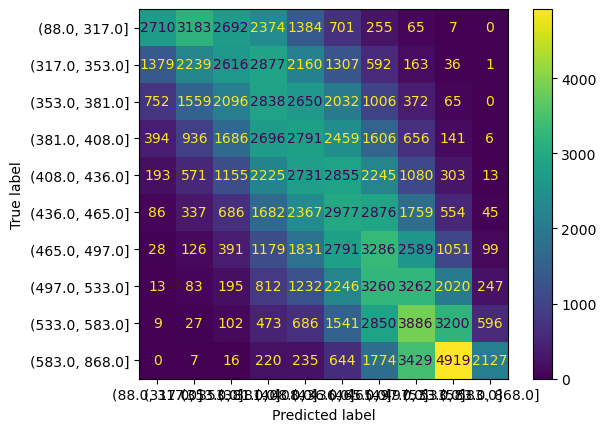

In [13]:
pipe_lr = Pipeline([
        ('imputer', SimpleImputer(add_indicator=True)), 
        ('scaler', StandardScaler()), 
        ('lr', LinearRegression())
    ])

print("Linear Regression Model")
print("coefficient of determination of the prediction:", pipe_lr.fit(X_train_all, y_train).score(X_test_all, y_test))

# Calculate MSE and MAE
y_pred_lr = pipe_lr.predict(X_test_all)
mse = mean_squared_error(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)

# Report results
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")

plot_confusion_regression(y_test, y_pred_lr, quartiles=10)

Y Test Binned Value Counts


(88.0, 291.0]     6686
(291.0, 317.0]    6685
(317.0, 336.0]    6685
(336.0, 353.0]    6685
(353.0, 367.0]    6685
(367.0, 381.0]    6685
(381.0, 395.0]    6686
(395.0, 408.0]    6685
(408.0, 422.0]    6685
(422.0, 436.0]    6686
(436.0, 450.0]    6687
(450.0, 465.0]    6682
(465.0, 480.0]    6685
(480.0, 497.0]    6686
(497.0, 514.0]    6685
(514.0, 533.0]    6685
(533.0, 555.0]    6686
(555.0, 583.0]    6684
(583.0, 621.0]    6685
(621.0, 868.0]    6686
Name: count, dtype: int64

Y Pred Binned Value Counts


(88.0, 291.0]      2357
(291.0, 317.0]     3207
(317.0, 336.0]     4106
(336.0, 353.0]     4962
(353.0, 367.0]     5415
(367.0, 381.0]     6220
(381.0, 395.0]     7223
(395.0, 408.0]    10153
(408.0, 422.0]     8668
(422.0, 436.0]     9399
(436.0, 450.0]     9512
(450.0, 465.0]    10041
(465.0, 480.0]     9454
(480.0, 497.0]    10296
(497.0, 514.0]     9028
(514.0, 533.0]     8233
(533.0, 555.0]     6977
(555.0, 583.0]     5319
(583.0, 621.0]     2668
(621.0, 868.0]      466
Name: count, dtype: int64

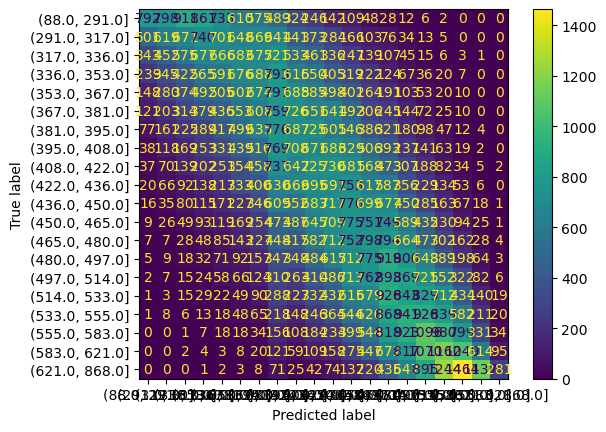

In [14]:
plot_confusion_regression(y_test, y_pred_lr, quartiles=20)

In [15]:
df_features = pd.DataFrame({ 
    "name": list(pipe_lr.named_steps["imputer"].get_feature_names_out()),
    "coef_": pipe_lr.named_steps['lr'].coef_
}).set_index("name")
df_features.abs().sort_values("coef_", ascending=False).head(10)

# ST253Q01JA: How many [digital devices] with screens are there in your [home]?
# ST268Q01JA: Agree/disagree: Mathematics is one of my favourite subjects.
# IC177Q05JA: How much time spent: Communicate and share digital content on social networks or any communication platform (e.g. [Facebook®], [Instagram®], [Twitter®], emails, chat)
# ST268Q02JA: Agree/disagree: [Test language] is one of my favourite subjects.
# MATHMOT: Motivation to do well in mathematics 
# MISSSC: Missing school for more than 3 months
# ST295Q01JA: How many days/wk after school: Eat dinner
# ST256Q06JA: How many of these books at [home]: Books on science
# ST258Q01JA: In the past 30 days, how often did you not eat because there was not enough money to buy food?
# IC174Q02JA: How often used [digital resources] to: Write or edit text for a school assignment (e.g. using [Google® Docs™], [Microsoft® Word])

,coef_
name,
ST253Q01JA,17.401960
ST268Q01JA,17.342308
IC177Q05JA,13.583389
ST268Q02JA,12.509331
MATHMOT,12.117775
MISSSC,12.009749
ST295Q01JA,11.728912
ST256Q06JA,10.856731
ST258Q01JA,10.544799
